In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers as tfkl, models as tfk
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/filtered6_dataset.csv"

# Load Data

In [ ]:
# Load the csv file
df = pd.read_csv(file_path)
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5,power_ratio,subject_id,label
0,0.180077,0.218750,0.421875,0.640625,0.182377,-0.129712,0.035568,7.611720,0.234375,0.952541,...,0.005288,1.560976,2.916588,5.748035,1.265770,0.279039,0.107661,4.196146,S001,N
1,0.116188,0.218750,0.421875,0.640625,0.116940,-0.142917,-0.011494,6.401779,0.187500,0.632139,...,0.004130,1.560976,0.942475,4.903048,1.170524,0.241586,0.010196,3.693372,S001,N
2,0.121023,0.218750,0.421875,0.648438,0.121389,-0.140039,-0.005806,6.333089,0.195312,0.619593,...,0.004146,1.560976,0.476099,4.853160,1.269356,0.336398,0.088376,3.344450,S001,N
3,0.138627,0.171875,0.328125,0.500000,0.139091,-0.075619,0.046283,4.516074,0.218750,0.440520,...,0.001843,2.000000,2.962109,3.009263,0.748133,0.258063,0.116591,3.100019,S001,N
4,0.068806,0.171875,0.328125,0.781250,0.069293,-0.078520,-0.000457,2.713990,0.156250,0.146076,...,0.001081,2.000000,0.029221,2.115377,0.439297,0.044651,0.016416,2.799579,S001,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.499998,0.226562,0.437500,0.734375,0.499998,-0.359638,0.019270,17.218056,0.140625,5.511694,...,0.040839,1.505882,1.637929,12.890518,7.828788,2.320222,0.230425,3.690086,S118,N
202384,0.550178,0.250000,0.476562,0.726562,0.550178,-0.391033,0.022467,19.873999,0.156250,7.070209,...,0.053460,1.376344,2.089437,14.987465,9.752007,2.597727,0.096489,4.069932,S118,N
202385,0.502216,0.250000,0.476562,0.726562,0.502216,-0.390489,-0.019317,19.858934,0.140625,6.572488,...,0.049566,1.376344,1.796471,14.453389,9.242147,3.022286,0.498451,4.203525,S118,N
202386,0.353672,0.234375,0.445312,0.679688,0.353672,-0.475695,-0.049775,14.960191,0.125000,4.601866,...,0.028173,2.942529,4.330394,8.686023,10.318711,2.294286,0.902660,5.407155,S118,N


In [ ]:
# Check the label distribution
df['label'].value_counts()

label
N    185476
S      9297
V      7615
Name: count, dtype: int64

# Scale

In [ ]:
variables_used = df.iloc[:,:-3] #no target

scaler = StandardScaler().fit(variables_used) # No target
scaled_df = pd.DataFrame(scaler.transform(variables_used))
scaled_df.columns = variables_used.columns

scaled_df.tail()

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,skewness,kurtosis,entropy,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,0.692315,0.133323,-0.238617,-0.361320,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,0.797146,0.271848,0.097535,-0.334111,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,0.998098,0.286549,-0.015070,-0.342504,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,-0.438068,0.960099,0.116681,-0.388626,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058
202387,0.399251,-0.195166,-0.198640,-0.046246,-0.025775,0.574028,0.759528,-0.297886,-0.244531,-0.354612,...,0.157787,-0.094742,0.028970,-0.348995,-0.233055,0.485731,-0.349265,-0.243900,-0.462108,-0.479117


In [ ]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
df = pd.concat([scaled_df, df['label'], df['subject_id']], axis=1)
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,entropy,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5,label,subject_id
0,-0.414807,-0.432072,-0.390309,-0.467345,-0.740741,0.764831,0.075085,-0.788937,0.120642,-0.479199,...,-0.260435,-0.437963,-0.085610,-0.413324,-0.722299,-0.796337,-0.717305,-0.601448,N,S001
1,-0.520770,-0.432072,-0.390309,-0.467345,-0.835862,0.746310,-0.131758,-0.824898,-0.244531,-0.483803,...,-0.380931,-0.440459,-0.085610,-0.542627,-0.758444,-0.804005,-0.723213,-0.627977,N,S001
2,-0.512751,-0.432072,-0.390309,-0.436021,-0.829395,0.750346,-0.106760,-0.826939,-0.183669,-0.483983,...,-0.328497,-0.440423,-0.085610,-0.573175,-0.760578,-0.796048,-0.708257,-0.606697,N,S001
3,-0.483554,-1.142789,-1.156986,-1.031184,-0.803662,0.840704,0.122178,-0.880942,-0.001082,-0.486556,...,-1.008617,-0.445389,0.635949,-0.410342,-0.839454,-0.838011,-0.720614,-0.599017,N,S001
4,-0.599355,-1.142789,-1.156986,0.096493,-0.905123,0.836635,-0.083248,-0.934501,-0.487979,-0.490787,...,-1.105305,-0.447033,0.635949,-0.602445,-0.877691,-0.862875,-0.754278,-0.626284,S,S001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,-0.238617,-0.361320,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033,N,S118
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,0.097535,-0.334111,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489,N,S118
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,-0.015070,-0.342504,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079,N,S118
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,0.116681,-0.388626,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058,N,S118


In [ ]:
# One-hot encode the labels
df = pd.get_dummies(df, columns=['label'])
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,dominant_frequency,fft1,fft2,fft3,fft4,fft5,subject_id,label_N,label_S,label_V
0,-0.414807,-0.432072,-0.390309,-0.467345,-0.740741,0.764831,0.075085,-0.788937,0.120642,-0.479199,...,-0.085610,-0.413324,-0.722299,-0.796337,-0.717305,-0.601448,S001,True,False,False
1,-0.520770,-0.432072,-0.390309,-0.467345,-0.835862,0.746310,-0.131758,-0.824898,-0.244531,-0.483803,...,-0.085610,-0.542627,-0.758444,-0.804005,-0.723213,-0.627977,S001,True,False,False
2,-0.512751,-0.432072,-0.390309,-0.436021,-0.829395,0.750346,-0.106760,-0.826939,-0.183669,-0.483983,...,-0.085610,-0.573175,-0.760578,-0.796048,-0.708257,-0.606697,S001,True,False,False
3,-0.483554,-1.142789,-1.156986,-1.031184,-0.803662,0.840704,0.122178,-0.880942,-0.001082,-0.486556,...,0.635949,-0.410342,-0.839454,-0.838011,-0.720614,-0.599017,S001,True,False,False
4,-0.599355,-1.142789,-1.156986,0.096493,-0.905123,0.836635,-0.083248,-0.934501,-0.487979,-0.490787,...,0.635949,-0.602445,-0.877691,-0.862875,-0.754278,-0.626284,S001,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033,S118,True,False,False
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489,S118,True,False,False
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079,S118,True,False,False
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058,S118,True,False,False


# Train/Test split

In [ ]:
# Separate the features and labels
X = df.drop(columns=['label_N', 'label_S', 'label_V'])
y = df[['label_N', 'label_S', 'label_V']]

In [ ]:
from collections import Counter

# Group the data by subject
grouped = df.groupby('subject_id')

# Create a list of subjects and the class distribution for each subject
subjects = list(grouped.groups.keys())
subject_class_distribution = []

for subject in subjects:
    # Sum the counts of each class label (N, S, V) for each subject
    label_counts = grouped.get_group(subject)[['label_N', 'label_S', 'label_V']].sum()
    subject_class_distribution.append(label_counts)

# Create a DataFrame to help with the split
subject_distribution_df = pd.DataFrame(subject_class_distribution).fillna(0)
subject_distribution_df['subject_id'] = subjects

# Sort subjects based on the proportion of the dominant class (sum of labels)
subject_distribution_df['dominant_class'] = subject_distribution_df[['label_N', 'label_S', 'label_V']].idxmax(axis=1)
subject_distribution_df = subject_distribution_df.sort_values(by=['dominant_class', 'label_N', 'label_S', 'label_V'], ascending=False)

# Split subjects while maintaining the proportions
train_subjects = []
test_subjects = []
train_distribution = Counter()
test_distribution = Counter()

for _, row in subject_distribution_df.iterrows():
    subject = row['subject_id']
    class_counts = Counter(grouped.get_group(subject)[['label_N', 'label_S', 'label_V']].sum().to_dict())

    if sum((train_distribution + class_counts).values()) <= len(df) * 0.7:
        train_subjects.append(subject)
        train_distribution += class_counts
    else:
        test_subjects.append(subject)
        test_distribution += class_counts

# Further split the training subjects into training and validation sets
train_subjects, val_subjects = train_test_split(train_subjects, test_size=0.2, random_state=42)

# Separate the train, validation, and test data based on the selected subjects
train_df = df[df['subject_id'].isin(train_subjects)]
val_df = df[df['subject_id'].isin(val_subjects)]
test_df = df[df['subject_id'].isin(test_subjects)]

# Separate the features and labels for train, validation, and test
X_train = train_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_train = train_df[['label_N', 'label_S', 'label_V']].copy()

X_val = val_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_val = val_df[['label_N', 'label_S', 'label_V']].copy()

X_test = test_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_test = test_df[['label_N', 'label_S', 'label_V']].copy()

# Convert y_train, y_val, and y_test into a binary label array
# We combine label_S and label_V as class 1, and keep label_N as class 0
y_train = y_train.apply(lambda x: 1 if x['label_S'] == True or x['label_V'] == True else 0, axis=1)
y_val = y_val.apply(lambda x: 1 if x['label_S'] == True or x['label_V'] == True else 0, axis=1)
y_test = y_test.apply(lambda x: 1 if x['label_S'] == True or x['label_V'] == True else 0, axis=1)

# Check the sizes and distribution
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train class distribution: {y_train.value_counts(normalize=True)}")
print(f"Validation class distribution: {y_val.value_counts(normalize=True)}")
print(f"Test class distribution: {y_test.value_counts(normalize=True)}")

Train shape: (110311, 22), Validation shape: (30941, 22), Test shape: (61136, 22)
Train class distribution: 0    0.941003
1    0.058997
Name: proportion, dtype: float64
Validation class distribution: 0    0.864096
1    0.135904
Name: proportion, dtype: float64
Test class distribution: 0    0.898603
1    0.101397
Name: proportion, dtype: float64


In [ ]:
# Shape andn class distribution of the sets
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train class distribution:")
print(f"Class 0 (Normal): {y_train.value_counts()[0]}")
print(f"Class 1 (Anomalous): {y_train.value_counts()[1]}")
print("Val class distribution:")
print(f"Class 0 (Normal): {y_val.value_counts()[0]}")
print(f"Class 1 (Anomalous): {y_val.value_counts()[1]}")
print("Test class distribution:")
print(f"Class 0 (Normal): {y_test.value_counts()[0]}")
print(f"Class 1 (Anomalous): {y_test.value_counts()[1]}")

Train shape: (110311, 22), Test shape: (61136, 22)
Train class distribution:
Class 0 (Normal): 103803
Class 1 (Anomalous): 6508
Val class distribution:
Class 0 (Normal): 26736
Class 1 (Anomalous): 4205
Test class distribution:
Class 0 (Normal): 54937
Class 1 (Anomalous): 6199


# Models

In [ ]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from sklearn.utils import class_weight

# Compute the classes' weights based on the training labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.flatten()), y=y_train.flatten())

# Convert classes' weights in a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {k: round(v, 4) for k, v in dict(enumerate(class_weights)).items()}

print("Class weights:", class_weights_dict)

Class weights: {0: 0.5313, 1: 8.475}


In [ ]:
# Define key model parameters
batch_size = 32                  # Batch size for training
epochs = 200                     # Number of training epochs
seed = 42                        # Random seed for reproducibility

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization

# Define the Neural Network
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu'),  # Third hidden layer
    Dropout(0.3),
    BatchNormalization(),
    Dense(16, activation='relu'),  # Firth hidden layer
    Dropout(0.3),
    BatchNormalization(),
    Dense(8, activation='relu'),  # Fifth hidden layer
    Dense(2, activation='softmax')  # Output layer
])

In [ ]:
import sys
sys.path.append('/content/drive/My Drive')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, label_binarize
import seaborn as sns
import cv2
from tensorflow.keras import layers as tfkl, Model, regularizers
import custom_bi as cm

In [ ]:
# Train the model
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Define early stopping callback and adaptive learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

# Model fit
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr, early_stopping],
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)

Epoch 1/200
3448/3448 [==============================] - 30s 7ms/step - loss: 0.3433 - accuracy: 0.8465 - val_loss: 0.2428 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 2/200
3448/3448 [==============================] - 24s 7ms/step - loss: 0.2599 - accuracy: 0.8955 - val_loss: 0.2200 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 3/200
3448/3448 [==============================] - 23s 7ms/step - loss: 0.2452 - accuracy: 0.8992 - val_loss: 0.2402 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 4/200
3448/3448 [==============================] - 23s 7ms/step - loss: 0.2366 - accuracy: 0.9120 - val_loss: 0.3415 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 5/200
3448/3448 [==============================] - 23s 7ms/step - loss: 0.2271 - accuracy: 0.9108 - val_loss: 0.2426 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 6/200
3448/3448 [==============================] - 23s 7ms/step - loss: 0.2192 - accuracy: 0.9140 - val_loss: 0.2368 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 7/200
3448/3448 [=======================

In [ ]:
# Test set predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confidence score for each prediction
confidence_scores = np.max(y_pred, axis=1)

# Precision, recall, and F1-score computation
precision = round(precision_score(y_test, y_pred_classes, average='macro'),2)
recall = round(recall_score(y_test, y_pred_classes, average='macro'),2)
f1 = round(f1_score(y_test, y_pred_classes, average='macro'),2)
custom = round(cm.custom_metric_binary(y_test, y_pred_classes),2)

# Confidence scores statistics
mean_confidence = round(np.mean(confidence_scores), 2)
std_confidence = round(np.std(confidence_scores), 2)
min_confidence = round(np.min(confidence_scores), 2)
max_confidence = round(np.max(confidence_scores), 2)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Custom Metric: {custom}")

print(f"Mean Confidence: {mean_confidence}")
print(f"Std Confidence: {std_confidence}")
print(f"Min Confidence: {min_confidence}")
print(f"Max Confidence: {max_confidence}")

1911/1911 [==============================] - 3s 2ms/step
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Custom Metric: 0.88
Mean Confidence: 0.9599999785423279
Std Confidence: 0.09000000357627869
Min Confidence: 0.5
Max Confidence: 1.0


In [ ]:
# Compute precision, recall, and F1-score for each class
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
f1_per_class = f1_score(y_test, y_pred_classes, average=None)
custom_per_class = cm.custom_metric_binary(y_test, y_pred_classes)

for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f"Class {i}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Custom Metric: {custom}")
    print("\n")

Class 0:
Precision: 0.986474909316272
Recall: 0.9851102171578353
F1 Score: 0.985792090930618
Custom Metric: 0.88


Class 1:
Precision: 0.8696414342629482
Recall: 0.8803032747217293
F1 Score: 0.874939874939875
Custom Metric: 0.88




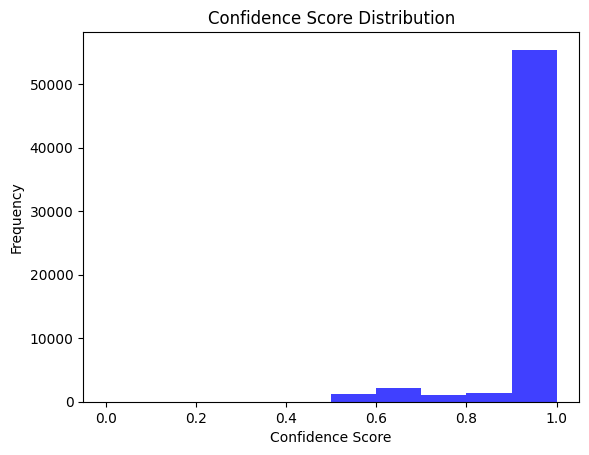

In [ ]:
plt.hist(confidence_scores, bins=10, range=(0, 1), alpha=0.75, color='blue')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

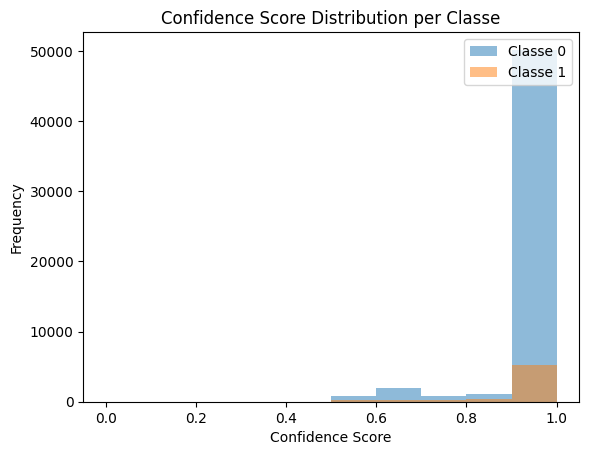

In [ ]:
# Raggruppare i confidence scores per classe predetta
class_confidences = {}
for cls in np.unique(y_pred_classes):
    class_confidences[cls] = confidence_scores[y_pred_classes == cls]

# Visualizzare la distribuzione dei confidence scores per ciascuna classe
for cls, confs in class_confidences.items():
    plt.hist(confs, bins=10, range=(0, 1), alpha=0.5, label=f'Classe {cls}')

plt.title('Confidence Score Distribution per Class')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calcolare statistiche per ogni classe
for cls, confs in class_confidences.items():
    mean_confidence = np.mean(confs)
    std_confidence = np.std(confs)
    min_confidence = np.min(confs)
    max_confidence = np.max(confs)
    print(f"Classe {cls}:")
    print(f"  Mean Confidence: {mean_confidence:.2f}")
    print(f"  Std Confidence: {std_confidence:.2f}")
    print(f"  Min Confidence: {min_confidence:.2f}")
    print(f"  Max Confidence: {max_confidence:.2f}")

Classe 0:
  Mean Confidence: 0.97
  Std Confidence: 0.09
  Min Confidence: 0.50
  Max Confidence: 1.00
Classe 1:
  Mean Confidence: 0.94
  Std Confidence: 0.12
  Min Confidence: 0.50
  Max Confidence: 1.00


In [ ]:
# Save the trained model
# model.save('/content/drive/My Drive/dl_final_model_binary.h5')